https://iopscience-iop-org.proxy-ub.rug.nl/article/10.1088/1361-648X/ac03d1/pdf

https://journals-aps-org.proxy-ub.rug.nl/prmaterials/abstract/10.1103/PhysRevMaterials.6.083801

https://www.sciencedirect.com/science/article/pii/S0141029624020224

## New Loss

Make a New Loss function to approximate the behavior

then train neural Net and also use Shenyangs base model to check

In [168]:
import numpy as np
import scipy.stats as stats

p_dpe = 0.2
sigma_1pe = 0.1
min_pe = 0

def truncnorm_pdf(x, mean=1, std=sigma_1pe, left_clip=min_pe):
    # Truncated normal dist
    return stats.norm.pdf(
        x,
        #(left_clip - mean)/std, float('inf'),
        loc=mean, scale=std)

def true_pdf(x, mu, max_sigma=4, std = sigma_1pe):
    """
    Probability density function for:
    - x: Expectation
    - mu : Observation 

    Computes number of Photoelectrons and photons without double photoelectron emission 

    Creates integer lists to compute likelihoods for each integer position within sigma for each

    Computes the truncated norm PDF for the observed signal vs each possible expected mean and standard deviation pair

    Does the same for Binomial for double photoelectron emission for difference photon to photelectron

    And for Poisson distribution of observed photons 

    Sums the entire thing after multiplication 
    """
    # Full dist
    n_pe_mle = np.clip(x, 0, None)
    n_ph_mle = np.clip(x / (1 + p_dpe), 0, None)
    
    n_ph = np.arange(1, n_ph_mle + max_sigma * n_ph_mle**0.5 + 2).reshape(-1, 1)
    n_pe = np.arange(1, n_pe_mle + max_sigma * n_pe_mle**0.5 + 2).reshape(1, -1)
    
    a = truncnorm_pdf(x, mean=n_pe, std=std * n_pe**0.5)
    b = stats.binom.pmf(n_pe - n_ph, n_ph, p_dpe)
    c = stats.poisson.pmf(n_ph, mu)

    return (a * b * c).sum()

def true_lr(x, mu, std = sigma_1pe, max_sigma = 4):
    """Do Log likelihood ratio"""
    # Result for x = 0 is trivial:
    result_zero = -2 * stats.poisson.logpmf(0, mu)
    mu_hat = np.clip(x / (1 + p_dpe), 1, None)
    # For x != zero:
    with np.errstate(divide='ignore', invalid='ignore'):
        result_nonzero = -2 * (np.log(true_pdf(x, mu, std = std, max_sigma=max_sigma)) 
                               - np.log(true_pdf(mu, mu_hat, std = std, max_sigma=max_sigma)))
        
    return np.where(x > min_pe, result_nonzero, result_zero)



obs 1 naive MLE 0.8333333333333334
std 0.9 : mle_estimate : 1.2160804020100504
std 0.5 : mle_estimate : 1.2160804020100504
std 0.1 : mle_estimate : 0.8120603015075377
obs 5 naive MLE 4.166666666666667
std 0.9 : mle_estimate : 4.448241206030151
std 0.5 : mle_estimate : 4.448241206030151
std 0.1 : mle_estimate : 4.0442211055276385
obs 10 naive MLE 8.333333333333334
std 0.9 : mle_estimate : 8.488442211055277
std 0.5 : mle_estimate : 8.488442211055277
std 0.1 : mle_estimate : 8.488442211055277
obs 20 naive MLE 16.666666666666668
std 0.9 : mle_estimate : 16.972864321608043
std 0.5 : mle_estimate : 16.972864321608043
std 0.1 : mle_estimate : 16.56884422110553
obs 40 naive MLE 33.333333333333336
std 0.9 : mle_estimate : 33.537688442211056
std 0.5 : mle_estimate : 33.537688442211056
std 0.1 : mle_estimate : 33.537688442211056
obs 60 naive MLE 50.0
std 0.9 : mle_estimate : 50.10251256281408
std 0.5 : mle_estimate : 50.10251256281408
std 0.1 : mle_estimate : 50.10251256281408


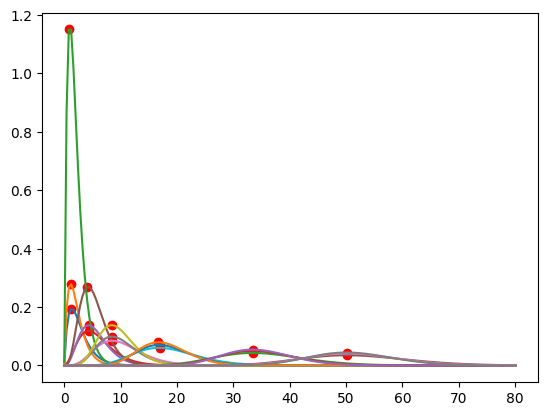

In [21]:
import matplotlib.pyplot as plt
obs = [1,5,10,20, 40, 60]
mle_options = np.linspace(-0.4, 80, 200)
print()
for obs_val in obs:
    print(f"obs {obs_val} naive MLE {obs_val/1.2}")
    to_plot = [true_pdf(obs_val, q, std=0.9, max_sigma=5) for q in mle_options]
    plt.plot(mle_options, to_plot, label=f"obs {obs_val}, std 0.9")
    plt.scatter(mle_options[np.nanargmax(to_plot)], np.nanmax(to_plot), color='red')
    print("std 0.9 : mle_estimate : {}".format(mle_options[np.nanargmax(to_plot)]))
    to_plot = [true_pdf(obs_val, q, std=0.5, max_sigma=5) for q in mle_options]
    plt.plot(mle_options, to_plot, label=f"obs {obs_val}, std 0.5")
    plt.scatter(mle_options[np.nanargmax(to_plot)], np.nanmax(to_plot), color='red')
    print("std 0.5 : mle_estimate : {}".format(mle_options[np.nanargmax(to_plot)]))
    to_plot = [true_pdf(obs_val, q, std=0.1, max_sigma=5) for q in mle_options]
    plt.plot(mle_options, to_plot, label=f"obs {obs_val}, std 0.1")
    plt.scatter(mle_options[np.nanargmax(to_plot)], np.nanmax(to_plot), color='red')
    print("std 0.1 : mle_estimate : {}".format(mle_options[np.nanargmax(to_plot)]))


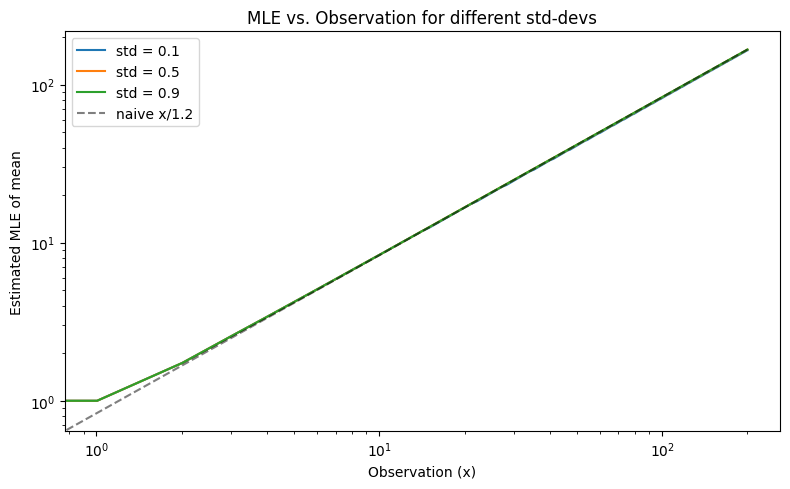

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# assume true_pdf(observed, mean, std, max_sigma=5) is already defined

def mle_mean(observed, std_dev, tol=1e-6):
    res = minimize_scalar(
        lambda m: -true_pdf(observed, m, std_dev),
        bounds=(0, 200),
        method='bounded',
        options={'xatol': tol}
    )
    return res.x

# 1) set up a range of observations and std-devs
obs_vals = np.linspace(0, 200, 200)
stds     = [0.1, 0.5, 0.9]

# 2) compute MLE curves
plt.figure(figsize=(8, 5))
for σ in stds:
    mles = [mle_mean(x, σ) for x in obs_vals]
    plt.plot(obs_vals, mles, label=f'std = {σ}')

# 3) optional: plot the naive x/1.2 line for comparison
plt.plot(obs_vals, obs_vals/1.2, '--', color='k', label='naive x/1.2', alpha=0.5)

# 4) finalize plot
plt.xlabel('Observation (x)')
plt.ylabel('Estimated MLE of mean')
plt.title('MLE vs. Observation for different std-devs')
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.show()


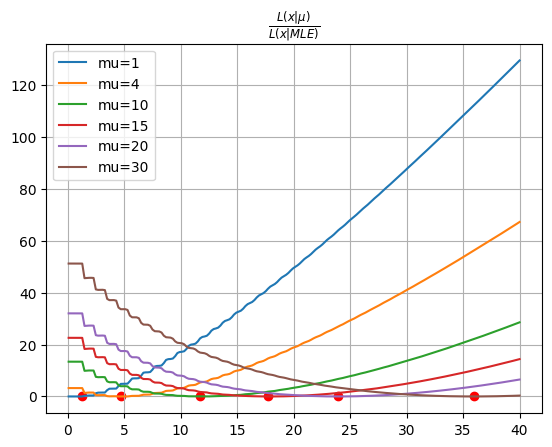

In [127]:
import matplotlib.pyplot as plt
mus = [1,4,10,15, 20,30]

x = np.linspace(0.1, 40, 200)
for mu in mus:
    tmp = [-2 * (np.log(true_pdf(q, mu, std = sigma_1pe, max_sigma=4)) 
                - np.log(true_pdf(q, np.clip(q / (1 + p_dpe), 1, None), 
                                  std = sigma_1pe, max_sigma=4)))
                    for q in x]
    plt.plot(x, tmp,label=f'mu={mu}')
    plt.scatter(x[np.argmin(tmp)], min(tmp), color='red')

plt.legend()
plt.title(r'$\frac{L(x|\mu)}{L(x|MLE)}$')
plt.grid()
plt.show()

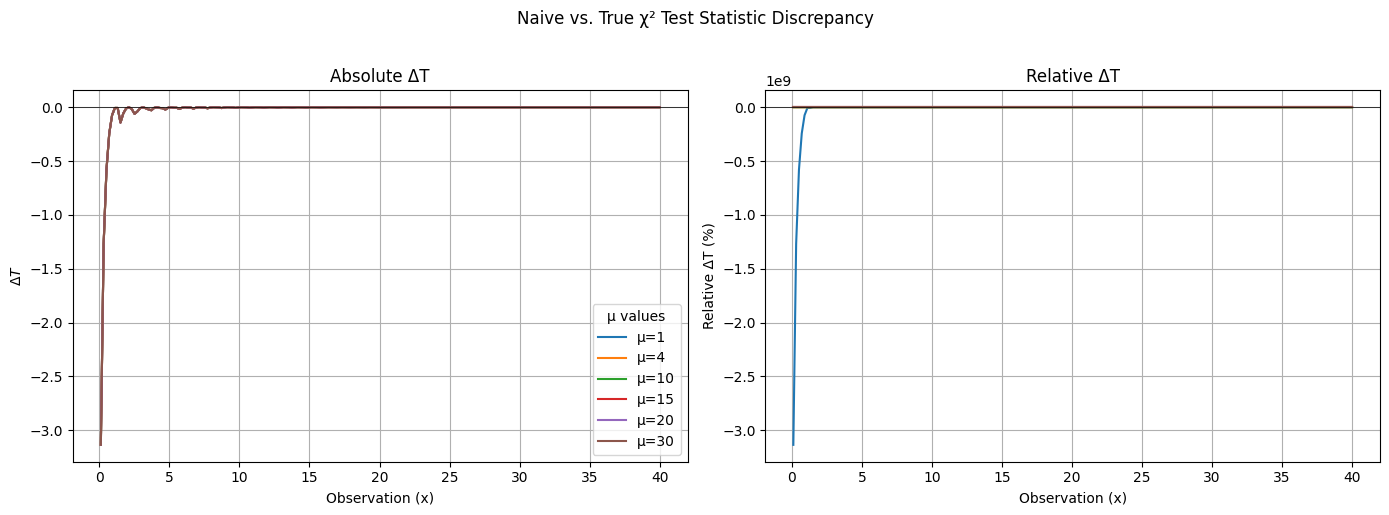

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# assume true_pdf(obs, mean, std, max_sigma), sigma_1pe, and p_dpe are defined

def mle_true(x):
    res = minimize_scalar(
        lambda m: -true_pdf(x, m, std=sigma_1pe, max_sigma=4),
        bounds=(0,40), method='bounded',
        options={'xatol':1e-6}
    )
    return res.x

def mle_naive(x):
    return x/1.2#np.clip(x/(1+p_dpe), 1, None)

x_vals = np.linspace(0.1, 40, 200)
mus    = [1, 4, 10, 15, 20, 30]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for mu in mus:
    # compute per-x values
    true_mles  = np.array([mle_true(x) for x in x_vals])
    naive_mles = np.array([mle_naive(x) for x in x_vals])

    logL_mu    = np.array([np.log(true_pdf(x,   mu, std=sigma_1pe, max_sigma=4))
                           for x in x_vals])
    logL_true  = np.array([np.log(true_pdf(x,   m,  std=sigma_1pe, max_sigma=4))
                           for x, m in zip(x_vals, true_mles)])
    logL_naive = np.array([np.log(true_pdf(x,   m,  std=sigma_1pe, max_sigma=4))
                           for x, m in zip(x_vals, naive_mles)])

    T_true  = -2*(logL_mu    - logL_true)
    T_naive = -2*(logL_mu    - logL_naive)

    deltaT     = T_naive - T_true
    rel_deltaT = (deltaT / np.maximum(T_true, 1e-7)) * 100

    axes[0].plot(x_vals, deltaT, label=f'μ={mu}')
    axes[1].plot(x_vals, rel_deltaT, label=f'μ={mu}')

# styling left plot
axes[0].axhline(0, color='k', lw=0.5)
axes[0].set_xlabel('Observation (x)')
axes[0].set_ylabel(r'$\Delta T$')
axes[0].set_title('Absolute ΔT')
axes[0].grid(True)

# styling right plot
axes[1].axhline(0, color='k', lw=0.5)
axes[1].set_xlabel('Observation (x)')
axes[1].set_ylabel('Relative ΔT (%)')
axes[1].set_title('Relative ΔT')
axes[1].grid(True)

fig.suptitle('Naive vs. True χ² Test Statistic Discrepancy (No naive clipping : mle = x/1.2)', y=1.02)
axes[0].legend(title='μ values')
plt.tight_layout()
plt.show()


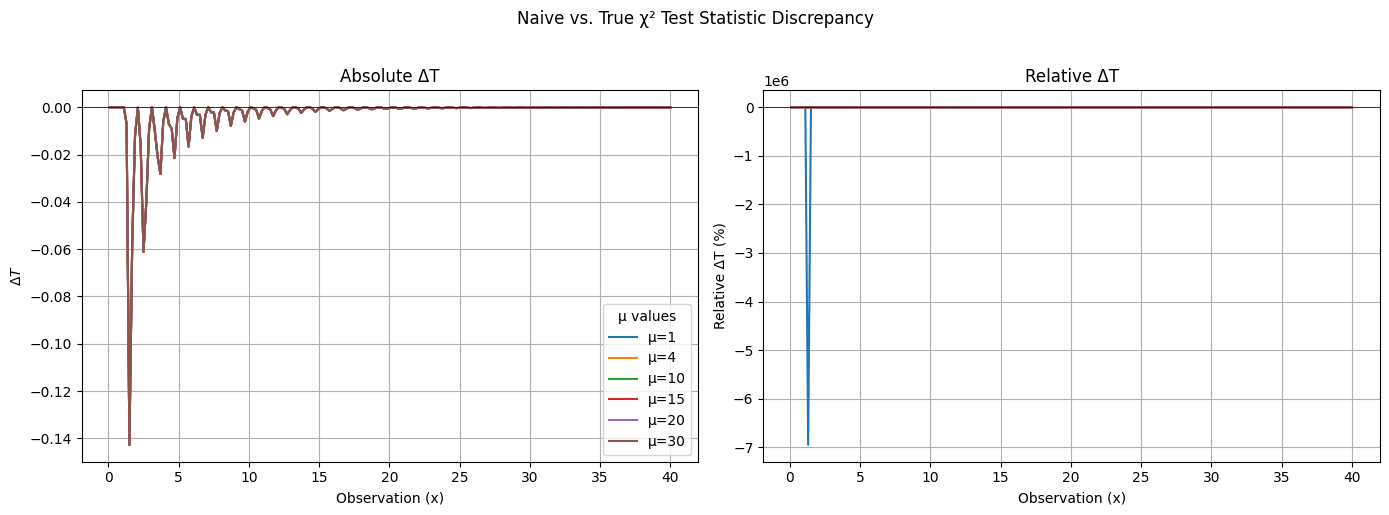

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# assume true_pdf(obs, mean, std, max_sigma), sigma_1pe, and p_dpe are defined

def mle_true(x):
    res = minimize_scalar(
        lambda m: -true_pdf(x, m, std=sigma_1pe, max_sigma=4),
        bounds=(0,40), method='bounded',
        options={'xatol':1e-6}
    )
    return res.x

def mle_naive(x):
    return np.clip(x/(1+p_dpe), 1, None)

x_vals = np.linspace(0.1, 40, 200)
mus    = [1, 4, 10, 15, 20, 30]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for mu in mus:
    # compute per-x values
    true_mles  = np.array([mle_true(x) for x in x_vals])
    naive_mles = np.array([mle_naive(x) for x in x_vals])

    logL_mu    = np.array([np.log(true_pdf(x,   mu, std=sigma_1pe, max_sigma=4))
                           for x in x_vals])
    logL_true  = np.array([np.log(true_pdf(x,   m,  std=sigma_1pe, max_sigma=4))
                           for x, m in zip(x_vals, true_mles)])
    logL_naive = np.array([np.log(true_pdf(x,   m,  std=sigma_1pe, max_sigma=4))
                           for x, m in zip(x_vals, naive_mles)])

    T_true  = -2*(logL_mu    - logL_true)
    T_naive = -2*(logL_mu    - logL_naive)

    deltaT     = T_naive - T_true
    rel_deltaT = (deltaT / np.maximum(T_true, 1e-7)) * 100

    axes[0].plot(x_vals, deltaT, label=f'μ={mu}')
    axes[1].plot(x_vals, rel_deltaT, label=f'μ={mu}')

# styling left plot
axes[0].axhline(0, color='k', lw=0.5)
axes[0].set_xlabel('Observation (x)')
axes[0].set_ylabel(r'$\Delta T$')
axes[0].set_title('Absolute ΔT')
axes[0].grid(True)

# styling right plot
axes[1].axhline(0, color='k', lw=0.5)
axes[1].set_xlabel('Observation (x)')
axes[1].set_ylabel('Relative ΔT (%)')
axes[1].set_title('Relative ΔT')
axes[1].grid(True)

fig.suptitle('Naive vs. True χ² Test Statistic Discrepancy (Naive clipping : mle = np.clip(x/1.2, 1, None))', y=1.02)
axes[0].legend(title='μ values')
plt.tight_layout()
plt.show()


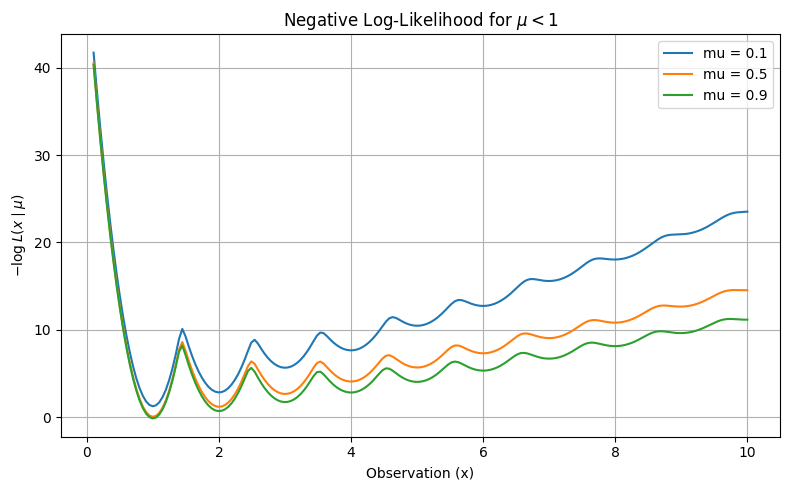

In [139]:
import numpy as np
import matplotlib.pyplot as plt

# assume true_pdf and sigma_1pe are already defined in the environment

# define range of observations
x_vals = np.linspace(0.1, 10, 200)

# mu values less than 1 to inspect
mu_vals = [0.1, 0.5, 0.9]

plt.figure(figsize=(8, 5))
for mu in mu_vals:
    # compute negative log-likelihood
    neg_logL = -np.log([true_pdf(q, mu, std=sigma_1pe, max_sigma=4) for q in x_vals])
    plt.plot(x_vals, neg_logL, label=f'mu = {mu}')

plt.xlabel('Observation (x)')
plt.ylabel(r'$-\log L(x \mid \mu)$')
plt.title('Negative Log-Likelihood (x|mu) for $\mu < 1$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_79/2776119830.py:26: RuntimeWarning: divide by zero encountered in log
  logL0 = np.log(true_pdf(x_obs, 0.0, std, max_sigma))


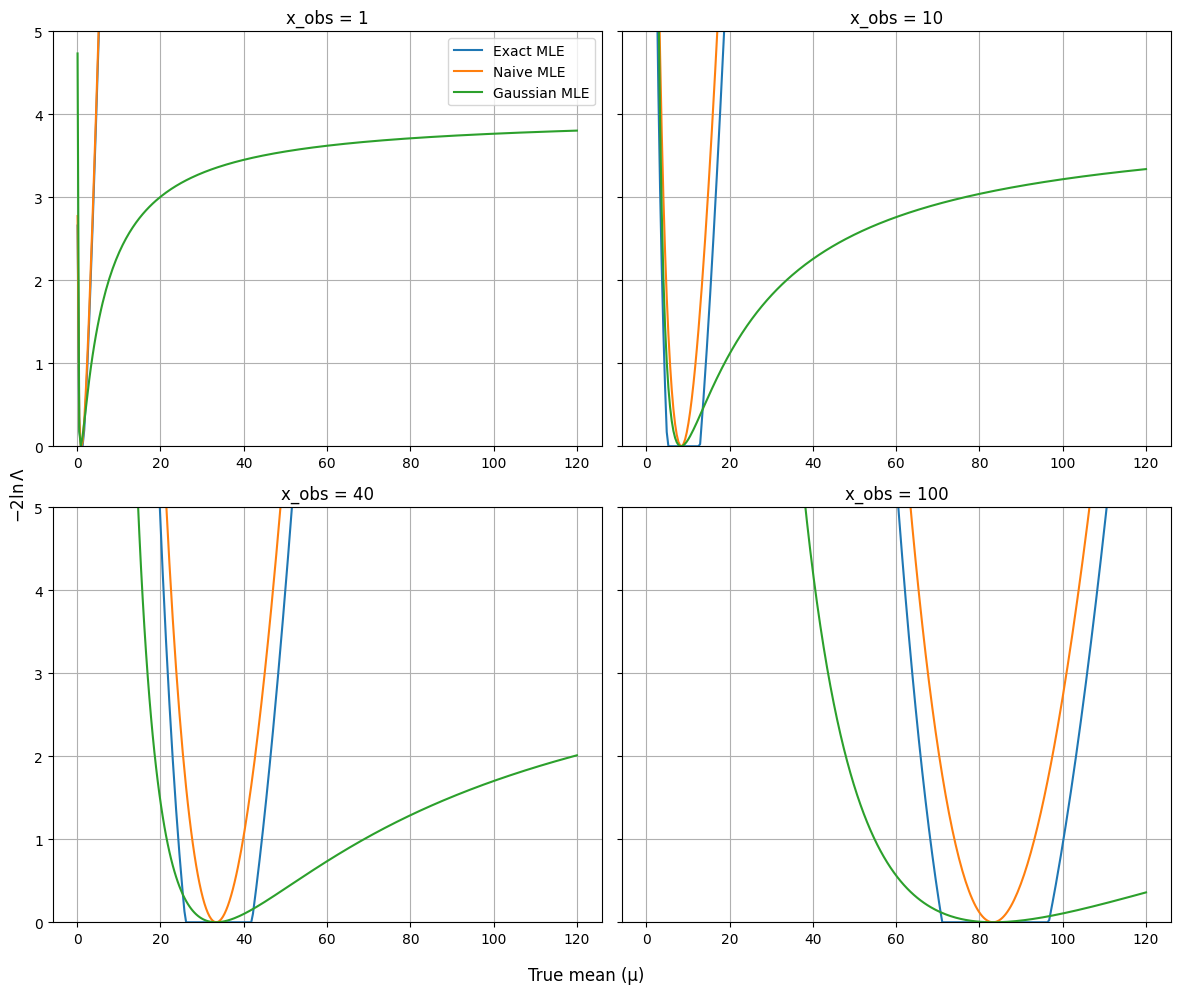

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def compute_common_std_np(mu, sigma_noise, p_dpe):
    """Return equivalent standard deviation due to Poisson detection + DPE emission + SPE variation
    mu: Number of photons expected
    """ 
    npe_mean = mu * (1 + p_dpe)
    # Note variance from Poisson is mu
    # but n_pe ~ (1 + p_dpe) n_ph
    # By square-linearity of the variance, we must scale my (1 + p_dpe)**2
    return (mu * (1 + p_dpe)**2
            + mu * p_dpe * (1 - p_dpe)
            + (npe_mean * sigma_noise)**2)**0.5


def gaussian_log_likelihood_np(x, mu, std, p_dpe):
    npe_mean = mu * (1 + p_dpe)
    sigma = compute_common_std_np(mu, std, p_dpe)
    return -0.5 * (np.log(2 * np.pi * sigma**2) + (x - npe_mean)**2 / sigma**2)

# --- MLE routines ---
def mle_true(x_obs, std, max_sigma=4, tol=1e-6):
    # compare L(mu=0) vs optimized
    logL0 = np.log(true_pdf(x_obs, 0.0, std, max_sigma))
    res = minimize_scalar(
        lambda m: -true_pdf(x_obs, m, std, max_sigma),
        bounds=(0, 120), method='bounded', options={'xatol': tol}
    )
    mu_hat = res.x
    logL_hat = np.log(true_pdf(x_obs, mu_hat, std, max_sigma))
    return 0.0 if logL0 >= logL_hat else mu_hat

def mle_naive(x_obs, p_dpe):
    return np.clip(x_obs / (1 + p_dpe), 0.0, 120.0)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# — assume true_pdf(x, mu, std, max_sigma), compute_common_std_np(mu, sigma_noise, p_dpe),
#   mle_true(x_obs, std), mle_naive(x_obs, p_dpe) are defined —

# constants
sigma_1pe = 0.5
p_dpe     = 0.2

# grid of true mu and list of fixed observations
mu_vals    = np.linspace(0.1, 120, 300)
x_obs_list = [1, 10, 40, 100]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

for ax, x_obs in zip(axes, x_obs_list):
    T_true, T_naive, T_gauss = [], [], []
    for mu in mu_vals:
        # exact LLR
        logL_x_mu = np.log(true_pdf(x_obs, mu, sigma_1pe))
        mu_t      = mle_true(x_obs, sigma_1pe)
        logL_t    = np.log(true_pdf(x_obs, mu_t, sigma_1pe))
        T_true .append(max(-2*(logL_x_mu - logL_t), 0.0))
        # naive LLR
        mu_n       = mle_naive(x_obs, p_dpe)
        logL_n     = np.log(true_pdf(x_obs, mu_n, sigma_1pe))
        T_naive.append(-2*(logL_x_mu - logL_n))
        # gaussian LLR (analytic)
        sigma2     = compute_common_std_np(mu, sigma_1pe, p_dpe)**2
        T_gauss.append((x_obs - mu*(1+p_dpe))**2 / sigma2)
    ax.plot(mu_vals, T_true,  label='Exact MLE',    color='C0')
    ax.plot(mu_vals, T_naive, label='Naive MLE',    color='C1')
    ax.plot(mu_vals, T_gauss, label='Gaussian MLE', color='C2')
    ax.set_title(f'x_obs = {x_obs}')
    ax.grid(True)
    ax.set_ylim(0, 5)
    if ax is axes[0]:
        ax.legend(loc='upper right')

fig.supxlabel('True mean (μ)')
fig.supylabel(r'$-2\ln\Lambda$')
plt.tight_layout()
plt.show()



# NN Unsuccesfull 

Try static compile with precomputed elements and misc timing 

In [39]:
# Base Full Computation
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp

tf.keras.mixed_precision.set_global_policy('float32')

class FullComputation(keras.layers.Layer):
    """
    Compute full likelihood ratio for static n_pe and n_ph
    """
    def __init__ (self,n_pmts,**kwargs):
        super().__init__(**kwargs)
        self.std = self.add_weight( 
                        shape=[n_pmts],
                        initializer = tf.constant_initializer(0.5),
                        trainable=True,
                        name="GaussianStandardDeviation"
                      )
        self.p_dpe = tf.constant(0.2, dtype=tf.float32, name="p_dpe_LossLayer")
        # Exact evaluation domain
        self.n_pe_domain = tf.range(0., 67.)[tf.newaxis,tf.newaxis,:]
        self.n_ph_domain = tf.range(0., 58.)[tf.newaxis,:,tf.newaxis]
            
    def build(self, input_shape):
        super().build(input_shape)
    def gaussian(self, x,std):
        std = std * tf.sqrt(self.n_pe_domain)
        mean = self.n_pe_domain
        return tfp.distributions.Normal(
                loc=mean, 
                scale=(std+1e-12), # Avoid 0 std and std abs on orig call
            ).prob(x)
    def true_likelihood(self, x, mu,std):
        """True Likelihood"""
        x = x[:,:,tf.newaxis] # (None, 1, 1)
        mu = mu[:,:,tf.newaxis] # (None, 1, 1)
        std = std[:,:,tf.newaxis] # (None, 1, 1)
        a = self.gaussian(x,std)
        #print(a.shape) (248000, 1, 248000, 66)
        # DPE emission
        # This can be entirely precomputed 
        b = tfp.distributions.Binomial(
                total_count=self.n_ph_domain, 
                probs=self.p_dpe
            ).prob(self.n_pe_domain - self.n_ph_domain)
        #print(b.shape) (1, 57, 66)
        # Photon detection
        c = tfp.distributions.Poisson(
                rate=mu).prob(self.n_ph_domain)
        #print(c.shape) (248000, 1, 57, 1)
        return tf.reduce_sum(a * b * c, axis=[1,2])

    def true_likelihoodRatio(self,x, mu,std):
        """Evaluates the true likelihood ratio"""
        return -2 *(tf.math.log(tf.maximum(self.true_likelihood(x, mu,std),1e-9)) 
                    - tf.maximum(tf.math.log(self.true_likelihood(x, x,std)),1e-10))
    
    @tf.function()
    def call(self, pred, observed):

        scaling = tf.math.reduce_sum(tf.where(observed > 0, observed, 0), axis=-1, keepdims=True)
        pred = pred * scaling

        batch_size = tf.shape(pred)[0]

        one  = tf.reshape(pred, [-1,1])
        two =tf.reshape(observed, [-1,1])
        three = tf.reshape(tf.tile(tf.expand_dims(self.std, axis=0), [batch_size, 1]), [-1,1])
        
        # Ensure tensors are fully evaluated before passing to map_fn
        # Because otherwise it passses a goddamn boolean for some reason 
        one = tf.ensure_shape(tf.identity(one), [None, 1])
        two = tf.ensure_shape(tf.identity(two), [None, 1])
        three = tf.ensure_shape(tf.identity(three), [None, 1])

        loss = self.true_likelihoodRatio(two, one, three)
        loss = tf.reshape(loss, (batch_size, -1))#tf.reduce_mean(tf.reshape(loss, (batch_size, -1)),axis=-1)
        return loss

class Precompute_Parts(keras.layers.Layer):
    """
    Compute full likelihood ratio for static n_pe and n_ph
    """
    def __init__ (self,n_pmts,**kwargs):
        super().__init__(**kwargs)
        self.std = self.add_weight( 
                        shape=[n_pmts],
                        initializer = tf.constant_initializer(0.5),
                        trainable=True,
                        name="GaussianStandardDeviation"
                      )
        self.p_dpe = tf.constant(0.2, dtype=tf.float32, name="p_dpe_LossLayer")

        # Exact evaluation domain
        self.n_pe_domain = tf.range(1., 67.)[tf.newaxis,tf.newaxis,:]
        self.n_ph_domain = tf.range(1., 58.)[tf.newaxis,:,tf.newaxis]

        # DPE emission
        self.b = tfp.distributions.Binomial(
                total_count=self.n_ph_domain, 
                probs=self.p_dpe
            ).prob(self.n_pe_domain - self.n_ph_domain)
        # Photon detection
        c_list = []
        for mu_val in range(41):
            c_val = tfp.distributions.Poisson(rate=float(mu_val)).prob(self.n_ph_domain)  
            # c_val: shape [num_ph_bins]
            c_list.append(c_val)
        # Stack => shape [41, num_ph_bins]
        self.c = tf.squeeze(tf.stack(c_list, axis=0)) #Because we have multiple newaxis in pe and ph domains
        return
            
    def build(self, input_shape):
        super().build(input_shape)
    def gaussian(self, x,std):
        std = std * tf.sqrt(self.n_pe_domain)
        mean = self.n_pe_domain
        return tfp.distributions.Normal(
                loc=mean, 
                scale=(std+1e-12), # Avoid 0 std and std abs on orig call
            ).prob(x)
    
    def true_likelihood(self, x, mu,std):
        """True Likelihood"""
        x = x[:,:,tf.newaxis] # (None, 1, 1)
        mu = mu[:,:,tf.newaxis] # (None, 1, 1)
        std = std[:,:,tf.newaxis] # (None, 1, 1)
        # This has to be computed every time
        a = self.gaussian(x,std)
        # Precomputed
        mu_idx = tf.cast(tf.squeeze(mu), tf.int32)        # (batch_size,)
        c_lookup = tf.gather(self.c, mu_idx)              # (batch_size, num_ph_bins)
        c_lookup = c_lookup[..., tf.newaxis]              # (batch_size, num_ph_bins, 1)
        return tf.reduce_sum(a * self.b * c_lookup, axis=[1,2])

    def true_likelihoodRatio(self,x, mu,std):
        """Evaluates the true likelihood ratio
        """
        return -2 *(tf.math.log(tf.maximum(self.true_likelihood(x, mu,std),1e-9)) 
                    - tf.maximum(tf.math.log(self.true_likelihood(x, x,std)),1e-10))
    
    @tf.function()
    def call(self, pred, observed):

        scaling = tf.math.reduce_sum(tf.where(observed > 0, observed, 0), axis=-1, keepdims=True)
        pred = pred * scaling

        batch_size = tf.shape(pred)[0]

        one  = tf.reshape(pred, [-1,1])
        two  = tf.reshape(observed, [-1,1])
        three = tf.reshape(tf.tile(tf.expand_dims(self.std, axis=0), [batch_size, 1]), [-1,1])
        
        # Ensure tensors are fully evaluated before passing to map_fn
        # Because otherwise it passses a goddamn boolean for some reason 
        one = tf.ensure_shape(tf.identity(one), [None, 1])
        two = tf.ensure_shape(tf.identity(two), [None, 1])
        three = tf.ensure_shape(tf.identity(three), [None, 1])


        loss = self.true_likelihoodRatio(two, one, three)
        loss = tf.reshape(loss, (batch_size, -1))#tf.reduce_mean(tf.reshape(loss, (batch_size, -1)),axis=-1)
        return loss
    

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

class Precompute_Everything(keras.layers.Layer):
    """
    Fully precompute the entire likelihood for all integer mu in [0..40], <- Each mu required in each computation
    a subdivided x in [0..40], and sigma in [0.05..1]. <- Look Up Table in x mu and sigma 
    We then do a simple nearest-index lookup in call().
    """
    def __init__(self, 
                 n_pmts, 
                 m=5,      # Subdivisions per integer in x
                 z=20,     # Steps for sigma
                 **kwargs):
        super().__init__(**kwargs)

        ############################################################
        # 1) Trainable parameter for the "log of the base std dev"
        #    (one per PMT).
        ############################################################
        self.std = self.add_weight(
            shape=[n_pmts],
            initializer=tf.constant_initializer(0.5),
            trainable=True,
            name="GaussianStandardDeviation"
        )

        ############################################################
        # 2) Constants
        ############################################################
        self.p_dpe   = tf.constant(0.2, dtype=tf.float32, name="p_dpe_LossLayer")

        # Domain for Poisson (n_ph) and Binomial+Gaussian (n_pe):
        # shapes used later for the sum
        # Make sure these are 1D Tensors of the correct shape:
        self.n_ph_domain = tf.range(0., 58., dtype=tf.float32)   # shape [57]
        self.n_pe_domain = tf.range(1., 67., dtype=tf.float32)   # shape [66]

        ############################################################
        # 3) Precompute b: the Binomial factor across (n_ph, n_pe)
        #
        # b.shape => (n_ph, n_pe)
        # We'll reshape in the big broadcast later.
        ############################################################
        binom = tfp.distributions.Binomial(
            total_count=self.n_ph_domain[..., tf.newaxis],  # shape (57,1)
            probs=self.p_dpe
        )
        # (n_ph, n_pe) = (57, 66)
        self.b = binom.prob(self.n_pe_domain[tf.newaxis, :] - self.n_ph_domain[..., tf.newaxis])

        ############################################################
        # 4) Precompute c: the Poisson factor for mu=0..40
        #
        # c.shape => (41, n_ph)
        ############################################################
        c_list = []
        for mu_val in range(41):
            # (n_ph,)
            c_val = tfp.distributions.Poisson(rate=float(mu_val)).prob(self.n_ph_domain)
            c_list.append(c_val)
        # shape (41, 57)
        self.c = tf.stack(c_list, axis=0)

        ############################################################
        # 5) Build the subdivided x_domain.  
        # If m=3, then for each integer i in [0..39], we produce i + [0,1/3,2/3],
        # plus the integer 40 as the final endpoint => total 40*m + 1 points.
        ############################################################
        x_vals = []
        for i in range(40):
            for sub in range(m):
                x_vals.append(i + sub / float(m))
        x_vals.append(40.0)  # final endpoint
        self.x_domain = tf.constant(x_vals, dtype=tf.float32)
        # shape = [nx], where nx = 40*m + 1

        ############################################################
        # 6) Build the sigma domain from 0.05..1 in z steps
        ############################################################
        self.sigma_domain = tf.linspace(0.05, 1.0, z)  # shape [z]

        ############################################################
        # 7) Build the 3D LUT: L_table[mu_idx, x_idx, sigma_idx].
        # We'll do a big broadcast multiply: a(x,sigma) * b(n_ph,n_pe) * c(mu,n_ph)
        # Then sum over n_ph,n_pe.
        #
        # Final shape = [41, nx, z].
        ############################################################

        # 7a) Reshape for broadcast:
        # c   => shape [41,   57] => turn into [41, 1, 1, 57, 1]
        c_broadcast = tf.reshape(self.c, [41, 1, 1, 57, 1])

        # b   => shape [57, 66]  => turn into [1, 1, 1, 57, 66]
        b_broadcast = tf.reshape(self.b, [1, 1, 1, 57, 66])

        # x_domain => shape [nx] => turn into [1, nx, 1, 1, 1]
        nx = tf.size(self.x_domain)
        x_broadcast = tf.reshape(self.x_domain, [1, nx, 1, 1, 1])

        # sigma_domain => shape [z] => turn into [1, 1, z, 1, 1]
        z_ = tf.size(self.sigma_domain)
        sigma_broadcast = tf.reshape(self.sigma_domain, [1, 1, z_, 1, 1])

        # n_pe_domain => shape [66] => [1, 1, 1, 1, 66]
        n_pe_broadcast = tf.reshape(self.n_pe_domain, [1, 1, 1, 1, 66])

        # n_ph_domain => shape [57] => [1, 1, 1, 57, 1]
        # (We already used this in c_broadcast).
        # We'll just reuse c_broadcast's shape for the n_ph dimension.

        # 7b) Build the Gaussian factor:
        # mean = n_pe_domain
        # std  = sigma * sqrt(n_pe_domain)
        # shape after broadcast => [1, nx, z, 1, 66]
        mean = n_pe_broadcast
        std  = sigma_broadcast * tf.sqrt(n_pe_broadcast + 1e-12)

        normal = tfp.distributions.Normal(loc=mean, scale=std + 1e-12)
        # a(x, sigma) => normal.prob(x)
        # shape => [1, nx, z, 1, 66]
        a_broadcast = normal.prob(x_broadcast)

        # 7c) Multiply: [41, nx, z, 57, 66] after broadcast
        # We'll do step by step.
        # shape( a ) = [1,   nx, z, 1,   66]
        # shape( b ) = [1,   1,   1, 57, 66]
        # shape( c ) = [41, 1,   1, 57, 1 ]
        # result => [41, nx, z, 57, 66]
        tmp = a_broadcast * b_broadcast  # => [1, nx, z, 57, 66]
        tmp = tmp * c_broadcast          # => [41, nx, z, 57, 66]

        # 7d) Sum over [57, 66] => axis -2, -1 => shape [41, nx, z]
        L_full = tf.reduce_sum(tmp, axis=[3,4])

        # 7e) Store as self.L_table: [41, nx, z]
        self.L_table = L_full  # big 3D table

    def build(self, input_shape):
        super().build(input_shape)

    ############################################################
    # Nearest-grid lookup
    ############################################################
    def lookup_likelihood(self, x, mu, std):
        """
        For each (x_i, mu_i, std_i), find the nearest index in x_domain, mu in [0..40],
        and sigma_domain, then return L_table[mu_idx, x_idx, sigma_idx].
        """
        # 1) mu_idx
        # Clip mu to [0,40], cast to int
        mu_clipped = tf.clip_by_value(mu, 0.0, 40.0)
        mu_idx = tf.cast(tf.round(mu_clipped), tf.int32)  # shape = ?

        # 2) x_idx
        # We assume x in [0..40]. We find the nearest index in self.x_domain.
        # Easiest way: scale x by 'm', or do a full search. We'll do a piecewise approach:
        #    x_idx ~ round( (x * (m)) ), but that only works if we constructed x_domain linearly.
        # But let's do a quick approximate method: we know x_domain is sorted,
        # we can do "tf.searchsorted(self.x_domain, x, side='left')" and clamp to edges.
        # Then decide if we need to step back by 1. 
        # For simplicity, let's do a function nearest_idx_1d(...).
        x_idx = self._nearest_idx_1d(self.x_domain, x)

        # 3) sigma_idx
        sigma_idx = self._nearest_idx_1d(self.sigma_domain, std)

        # 4) Gather from L_table. We want shape (batch_size,).
        # We'll use tf.gather_nd. We need to build indices of shape [batch_size, 3].
        # Each row is [mu_idx[i], x_idx[i], sigma_idx[i]].
        coords = tf.stack([mu_idx, x_idx, sigma_idx], axis=-1)  # shape (batch_size, 3)
        vals = tf.gather_nd(self.L_table, coords)               # shape (batch_size,)
        return vals

    def _nearest_idx_1d(self, grid, values):
        """
        Return nearest indices in 'grid' for each 'values'.
        grid: shape [N], sorted
        values: shape [batch_size], or any shape
        Output: same shape as 'values', containing integer indices in [0, N-1].
        """
        # searchsorted gives the insertion index. Then we clamp & decide which neighbor is closer.
        idx_float = tf.searchsorted(grid, values, side='left')  # shape = same as values
        # idx_float is in [0..N], clamp
        idx_below = tf.clip_by_value(idx_float - 1, 0, tf.size(grid)-1)
        idx_above = tf.clip_by_value(idx_float,     0, tf.size(grid)-1)

        # pick whichever is closer to 'values'
        below_vals = tf.gather(grid, idx_below)
        above_vals = tf.gather(grid, idx_above)

        dist_below = tf.abs(values - below_vals)
        dist_above = tf.abs(values - above_vals)

        choice = tf.cast(dist_above < dist_below, tf.int32)  # 1 if 'above' is nearer
        # final index
        idx_nearest = idx_below + choice  # shape same as values
        return idx_nearest

    ############################################################
    # -2 log-likelihood ratio
    ############################################################
    def true_likelihoodRatio(self, x, mu, std):
        """
        -2 * [ log L(x| mu, std) - log L(mu | mu, std) ]
        with a small floor to keep logs stable.
        """
        like_x = tf.maximum(self.lookup_likelihood(x, mu, std), 1e-9)
        like_mu= tf.maximum(self.lookup_likelihood(x, x, std), 1e-9)

        return -2.0 * (tf.math.log(like_x) - tf.math.log(like_mu))

    @tf.function
    def call(self, pred, observed):
        """
        pred: shape [batch, n_pmts]   (floating in [0..some range])
        observed: shape [batch, n_pmts]
        We do scaling, reshape, then do the ratio across all PMTs, and reduce_mean.
        """
        # 1) Scale the predicted fraction by sum of observed (like in your code).
        scaling = tf.reduce_sum(tf.where(observed > 0, observed, 0), axis=-1, keepdims=True)
        pred = pred * scaling

        # 2) Flatten out
        batch_size = tf.shape(pred)[0]
        one   = tf.reshape(pred,    [-1])  # shape [batch_size * n_pmts]
        two   = tf.reshape(observed,[-1])
        # exponentiate the learned log_std for each PMT
        std = tf.reshape(self.std, [1, -1])  # shape [1, n_pmts]
        std = tf.tile(std, [batch_size, 1])            # shape [batch_size, n_pmts]
        three = tf.reshape(std, [-1])                      # shape [batch_size * n_pmts]

        # 3) Evaluate likelihood ratio (per PMT)
        #   shape => [batch_size * n_pmts]
        ratio = self.true_likelihoodRatio(two, one, three)

        # 4) Average over PMTs => shape [batch_size]
        ratio_2d = tf.reshape(ratio, (batch_size, -1))
        #loss = tf.reduce_mean(ratio_2d, axis=-1)
        loss = ratio_2d
        return loss

"""
Trialed Gaussian Approx only, have to enforce minimum computation PE otherwise the loss blows up (1e10 after clipping inf to 1e5 <- Any higher I get NaN), 
-> Gaussian does not work at all in low PE regime 
-> Could try Poisson Binom only but need Gaussian for negative responses
-> Could do:
     < 20 Only Poisson
     < 0 Full loss
     > 20 Only Gaussian
"""
class GaussianApprox(keras.layers.Layer):
    """
    Computes Likelihood space to max_sigma
    switches to gaussian approximation when signal is > self.switching_signal
    This is since it becomes increasingly costly to evaluate exactly
    
    """
    def __init__ (self,n_pmts, **kwargs):
        super().__init__(**kwargs)
        self.std = self.add_weight( 
                        shape=[n_pmts],
                        initializer = tf.constant_initializer(0.5),
                        trainable=True,
                        name="GaussianStandardDeviation"
                      )
        self.p_dpe = tf.constant(0.2, dtype=tf.float32, name="p_dpe_LossLayer")
            
    def build(self, input_shape):
        super().build(input_shape)

    def compute_common_std(self, mu,std):
        """
        Compute Gaussian Limit equivalent standard deviation
        mu is (n_pmts) 

        Nan fighting : tf.abs on npe_mean -> Will be high loss anyway
        """
        npe_mean = mu * (1 + self.p_dpe)
        return tf.sqrt(tf.abs(
                mu * (1 + self.p_dpe)**2 +          #Poisson 
                mu * self.p_dpe * (1-self.p_dpe) +  # Binom 
                (tf.abs(npe_mean)* (std+1e-12)**2 ) # Gaussian
                )) 
    
    def gaussian_approx(self, x, mu,std):
        """Gaussian Approximation Likelihood"""
        npe_mean = mu * (1 + self.p_dpe)
        return tfp.distributions.Normal(
            loc=npe_mean,
            scale=self.compute_common_std(mu,std)
        ).log_prob(x)
    
    def approximate_likelihoodRatio(self, x, mu, std):
        """Evaluates In gaussian Limit
        
        x is MLE for Gauss
        """
        return -2 * (self.gaussian_approx(x, mu, std)
                   - self.gaussian_approx(mu, mu, std))

    @tf.function()#experimental_relax_shapes=True)
    def call(self, pred, observed):
        """We need to evaluate per PMT per batch element
        We no longer evaluate the likelihood of observing PE but the likelihood of observing Ph
        So we scale according to most likely number of photons as observed from data and scale according to that
        rather than full PE response
        """
        scaling = tf.math.reduce_sum(tf.where(observed > 0, observed, 0), axis=-1, keepdims=True)
        pred = pred * scaling

        batch_size = tf.shape(pred)[0]
        one  = tf.reshape(pred, [-1,1])
        two =tf.reshape(observed, [-1,1])
        three = tf.reshape(tf.tile(tf.expand_dims(self.std, axis=0), [batch_size, 1]), [-1,1])

        one = tf.ensure_shape(tf.identity(one), [None, 1])
        two = tf.ensure_shape(tf.identity(two), [None, 1])
        three = tf.ensure_shape(tf.identity(three), [None, 1])
        
        loss = self.approximate_likelihoodRatio(one, two, three)
        # Mean
        loss =tf.reshape(loss, (batch_size, -1))# tf.reduce_mean(tf.reshape(loss, (batch_size, -1)),axis=-1)
        
        return loss

In [42]:

FullComputation(1)(np.array([[0.1]]).astype('float32'), np.array([[-10]]).astype('float32'))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[94.8707]], dtype=float32)>

In [7]:
import time
import tensorflow as tf
n_pmts = 248
x_sample = tf.random.normal((1000,n_pmts)) 
# Make each subarray have minimum 0
x_sample += tf.reduce_min(x_sample, axis=-1, keepdims=True)
x_sample /= tf.reduce_sum(x_sample, axis=-1, keepdims=True)
mu_sample = tf.random.uniform((1000,n_pmts), minval=0, maxval=40)

def measure_model(model, x, mu, n_calls=1000):
    """
    Measures initialization time, compilation (first call) time,
    and post-compilation speed for `n_calls` calls.
    """
    # Initialization timing
    init_start = time.time()
    m = model(n_pmts)  # Create a new instance
    init_end = time.time()

    init_time = init_end - init_start

    # Compilation (first call) timing
    compile_start = time.time()
    _ = m(x, mu)  # first call triggers compilation
    compile_end = time.time()

    compile_time = compile_end - compile_start

    # Post-compilation calls
    post_start = time.time()
    for _ in range(n_calls):
        _ = m(x, mu)
    post_end = time.time()

    post_comp_time = post_end - post_start

    return init_time, compile_time, post_comp_time

# Compare the three models
for model_class in [FullComputation, Precompute_Parts, Precompute_Everything, GaussianApprox]:
    init_t, compile_t, post_t = measure_model(model_class, x_sample, mu_sample)
    print(f"\n===== {model_class.__name__} =====")
    print(f"Initialization time:  {init_t:.4f} s")
    print(f"Compilation time:     {compile_t:.4f} s")
    print(f"Post-comp. time (for calls): {post_t:.4f} s")


===== FullComputation =====
Initialization time:  0.0014 s
Compilation time:     0.6127 s
Post-comp. time (for calls): 522.4406 s

===== Precompute_Parts =====
Initialization time:  0.0149 s
Compilation time:     0.5600 s
Post-comp. time (for calls): 521.5783 s

===== Precompute_Everything =====
Initialization time:  0.1309 s
Compilation time:     0.0630 s
Post-comp. time (for calls): 2.7628 s

===== GaussianApprox =====
Initialization time:  0.0015 s
Compilation time:     0.1223 s
Post-comp. time (for calls): 1.1722 s


In [8]:
def approximate_layer_size_bytes(layer):
    """
    Approximate the memory usage of the large Tensors in 'layer' 
    by summing #elements * dtype size (in bytes).
    """
    total_bytes = 0
    
    # 1) Check trainable & non-trainable Variables
    for var in layer.trainable_variables + layer.non_trainable_variables:
        n_elems = tf.reduce_prod(var.shape)
        dtype_size = var.dtype.size  # e.g. 4 for float32
        total_bytes += n_elems.numpy() * dtype_size
    
    # 2) Check other big Tensors stored as attributes (e.g. self.L_table)
    #    if they're tf.Tensor or tf.Variable. 
    #    For example, in your code: self.L_table, self.b, self.c...
    possibly_big_tensors = [layer.b, layer.c, layer.L_table, layer.n_pe_domain, layer.n_ph_domain]
    for t in possibly_big_tensors:
        if isinstance(t, tf.Tensor):
            n_elems = tf.reduce_prod(t.shape)
            dtype_size = t.dtype.size
            total_bytes += n_elems.numpy() * dtype_size
    
    return total_bytes

def print_layer_size(layer):
    size_bytes = approximate_layer_size_bytes(layer)
    size_mb = size_bytes / (1024 * 1024)
    print(f"Approximate layer size: {size_mb:.2f} MB ({size_bytes} bytes)")

layer = Precompute_Everything(n_pmts=248, m=3, z=10)
# The big precomputation usually happens in __init__ or build(). 
# Then do:
print_layer_size(layer)

Approximate layer size: 0.21 MB (224320 bytes)


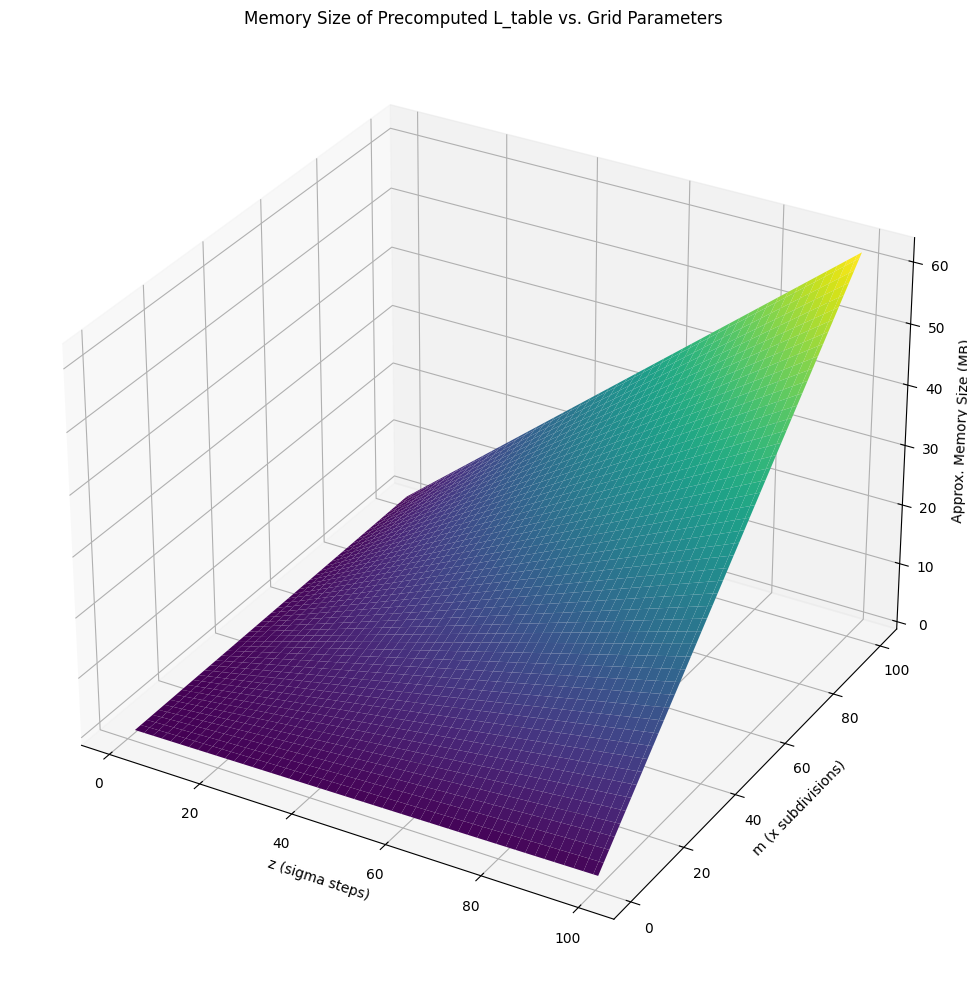

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
num_mu = 41            # mu in [0..40]
num_x_per_int = np.arange(1, 101)  # m values
num_sigma_steps = np.arange(1, 101)  # z values
float_size_bytes = 4   # float32

# Domain sizes
n_ph = 57
n_pe = 66

# Output array
sizes_mb = np.zeros((len(num_x_per_int), len(num_sigma_steps)))

for i, m in enumerate(num_x_per_int):
    nx = 40 * m + 1
    for j, z in enumerate(num_sigma_steps):
        # L_table shape: (41, nx, z)
        table_size = num_mu * nx * z * float_size_bytes
        # Add precomputed arrays: b (57x66), c (41x57)
        b_size = n_ph * n_pe * float_size_bytes
        c_size = num_mu * n_ph * float_size_bytes
        total_size = table_size + b_size + c_size
        sizes_mb[i, j] = total_size / (1024 * 1024)  # Convert to MB

# Plotting
X, Y = np.meshgrid(num_sigma_steps, num_x_per_int)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, sizes_mb, cmap='viridis')
ax.set_xlabel("z (sigma steps)")
ax.set_ylabel("m (x subdivisions)")
ax.set_zlabel("Approx. Memory Size (MB)")
ax.set_title("Memory Size of Precomputed L_table vs. Grid Parameters")

plt.tight_layout()
plt.show()


Running m=1
Running m=3
Running m=5
Running m=7
Running m=9
Running m=11
Running m=13
Running m=15
Running m=17
Running m=19
Running m=21
Running m=23
Running m=25
Running m=27
Running m=29
Running m=31


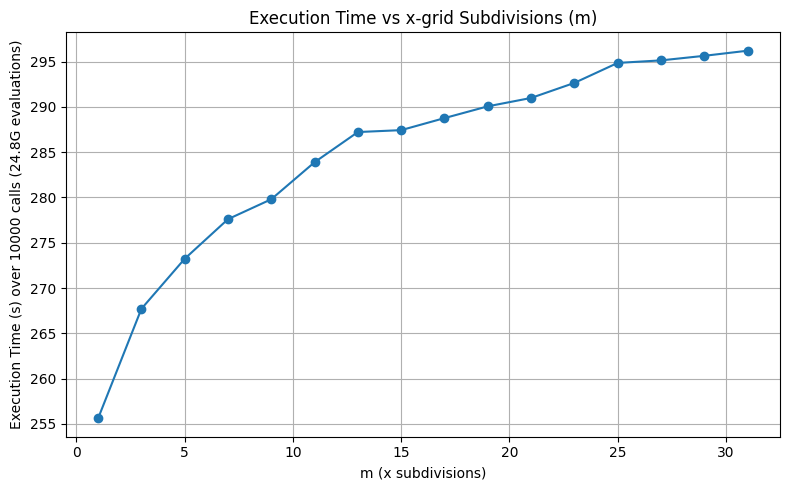

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import gc
# Sample inputs
n_pmts = 248
x_sample = tf.random.normal((10000, n_pmts))
x_sample += tf.reduce_min(x_sample, axis=-1, keepdims=True)
x_sample /= tf.reduce_sum(x_sample, axis=-1, keepdims=True)
mu_sample = tf.random.uniform((10000, n_pmts), minval=0, maxval=40)

def measure_execution_time(m_val, x, mu, n_calls=10000):
    model = Precompute_Everything(n_pmts, m=m_val, z=10)
    _ = model(x, mu)  # trigger compilation
    time.sleep(1)
    start = time.time()
    for _ in range(n_calls):
        _ = model(x, mu)
    end = time.time()
    return end - start

# Range of m
m_vals = np.arange(1, 33, 2)
times = []

for m in m_vals:
    print(f"Running m={m}")
    t = measure_execution_time(m, x_sample, mu_sample)
    times.append(t)
    gc.collect()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(m_vals, times, marker='o')
plt.xlabel("m (x subdivisions)")
plt.ylabel("Execution Time (s) over 10000 calls ({}G evaluations)".format(n_pmts*0.100))
plt.title("Execution Time vs x-grid Subdivisions (m)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import gc

# Placeholder imports; ensure these are defined in your environment
# from your_module import FullComputation, Precompute_Parts, Precompute_Everything

# --- Configuration ---
n_pmts = 248
batch_size = 100
m_values = list(range(1, 17,2))

# --- Generate consistent x and mu inputs ---
x_raw = tf.random.normal((batch_size, n_pmts))
x_raw = x_raw - tf.reduce_min(x_raw, axis=-1, keepdims=True)
x_vals = x_raw / tf.reduce_sum(x_raw, axis=-1, keepdims=True)

mu_vals = tf.random.uniform((batch_size, n_pmts), minval=0.0, maxval=40.0)

# --- Helper function to compute metrics ---
def compute_metrics(pred, ref):
    abs_error = np.abs(pred - ref)
    mae = np.mean(abs_error)
    mae_std = np.std(abs_error)

    eps = 1e-7
    perc_error = np.abs((pred - ref) / np.maximum(np.abs(ref), eps))
    mape = np.mean(perc_error)
    mape_std = np.std(perc_error)

    return mae, mae_std, mape, mape_std

import numpy as np
import tensorflow as tf
import pandas as pd
import gc

# Ensure your classes are available in scope:
# from your_module import FullComputation, Precompute_Parts, Precompute_Everything

# --- Configuration ---
n_pmts = 248
batch_size = 1000
m_values = list(range(1, 17,2))
z_val = 20  # So sigma=0.5 is included if relevant

# --- Generate consistent x and mu inputs ---
x_raw = tf.random.normal((batch_size, n_pmts))
x_raw = x_raw - tf.reduce_min(x_raw, axis=-1, keepdims=True)
x_vals = x_raw / tf.reduce_sum(x_raw, axis=-1, keepdims=True)

mu_vals = tf.random.uniform((batch_size, n_pmts), minval=0.0, maxval=40.0)

# --- Helper function to compute metrics ---
def compute_metrics(pred, ref):
    abs_error = np.abs(pred - ref)
    mae = np.mean(abs_error)
    mae_std = np.std(abs_error)

    eps = 1e-7
    perc_error = np.abs((pred - ref) / np.maximum(np.abs(ref), eps))
    mape = np.mean(perc_error)
    mape_std = np.std(perc_error)
    mape_min = np.min(perc_error)
    mape_max = np.max(perc_error)

    return mae, mae_std, mape, mape_std, mape_min, mape_max

# --- Storage for results ---
results = []

# --- FullComputation (baseline) ---
baseline_model = FullComputation(n_pmts)
baseline_pred = tf.reshape(baseline_model(x_vals, mu_vals), [-1]).numpy()
results.append({
    "Model": "FullComputation (baseline)",
    "Parameter": "-",
    "MAE": 0.0,
    "MAE_std": 0.0,
    "MAPE": 0.0,
    "MAPE_std": 0.0,
    "MAPE_min": 0.0,
    "MAPE_max": 0.0,
})

# --- Precompute_Parts ---
parts_model = Precompute_Parts(n_pmts)
parts_pred = tf.reshape(parts_model(x_vals, mu_vals), [-1]).numpy()
mae, mae_std, mape, mape_std, mape_min, mape_max = compute_metrics(parts_pred, baseline_pred)
results.append({
    "Model": "Precompute_Parts",
    "Parameter": "-",
    "MAE": mae,
    "MAE_std": mae_std,
    "MAPE": mape,
    "MAPE_std": mape_std,
    "MAPE_min": mape_min,
    "MAPE_max": mape_max,
})

# --- Precompute_Everything for m = 1 to 31 ---
for m in m_values:
    try:
        model = Precompute_Everything(n_pmts, m=m, z=z_val)
        pred = tf.reshape(model(x_vals, mu_vals), [-1]).numpy()
        mae, mae_std, mape, mape_std, mape_min, mape_max = compute_metrics(pred, baseline_pred)
        results.append({
            "Model": "Precompute_Everything",
            "Parameter": f"m={m}",
            "MAE": mae,
            "MAE_std": mae_std,
            "MAPE": mape,
            "MAPE_std": mape_std,
            "MAPE_min": mape_min,
            "MAPE_max": mape_max,
        })
    except Exception as e:
        results.append({
            "Model": "Precompute_Everything",
            "Parameter": f"m={m}",
            "MAE": np.nan,
            "MAE_std": np.nan,
            "MAPE": np.nan,
            "MAPE_std": np.nan,
            "MAPE_min": np.nan,
            "MAPE_max": np.nan,
            "Error": str(e)
        })
    gc.collect()

# --- Display Results ---
df_results = pd.DataFrame(results)
print("\nModel Evaluation Results:\n")
print(df_results.to_string(index=False))

# Optional: save to disk
# df_results.to_csv("evaluation_results.csv", index=False)




Model Evaluation Results:

                     Model Parameter      MAE  MAE_std     MAPE  MAPE_std     MAPE_min  MAPE_max
FullComputation (baseline)         - 0.000000 0.000000 0.000000  0.000000 0.000000e+00  0.000000
          Precompute_Parts         - 0.664121 1.621453 0.046947  0.168711 0.000000e+00 14.742595
     Precompute_Everything       m=1 5.923805 3.965384 0.593895  0.304185 6.941487e-05  1.094827
     Precompute_Everything       m=3 5.934323 3.953514 0.594722  0.303708 2.586440e-05  1.217316
     Precompute_Everything       m=5 5.934853 3.952862 0.594770  0.303685 9.088403e-06  1.134884
     Precompute_Everything       m=7 5.935063 3.952779 0.594789  0.303678 6.366061e-05  1.168507
     Precompute_Everything       m=9 5.935180 3.952690 0.594796  0.303673 3.220497e-07  1.128820
     Precompute_Everything      m=11 5.935317 3.952609 0.594800  0.303665 3.114795e-05  1.156257
     Precompute_Everything      m=13 5.935213 3.952609 0.594795  0.303670 1.577678e-05  1.155866
  

# Now That we know that it works make it work as the full loss

Some things that need adressing:
- For PE > 40 use Gaussian
- trainable stds now need to be indices as they are no longer continuous 
    - Could do variable range but that will increase computational time in computing indexes

In [80]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

class LikelihoodRatioLUT(keras.layers.Layer):
    """
    Fully precompute the entire likelihood for all integer mu in [0..40], <- Each mu required in each computation
    a subdivided x in [0..40], and sigma in [0.05..1]. <- Look Up Table in x mu and sigma 
    We then do a simple nearest-index lookup in call().

    Around 2 orders of magnitude faster than recomputing every time
    """
    def __init__(self, 
                 n_pmts, 
                 m=5,      # Subdivisions per integer in x
                 z=20,     # Steps for sigma
                 switching_signal = 40, 
                 **kwargs):
        super().__init__(**kwargs)

        ############################################################
        # 1) Trainable parameter for the "log of the base std dev"
        #    (one per PMT).
        ############################################################
        self.std = self.add_weight(
            shape=[n_pmts],
            initializer=tf.constant_initializer(0.5),
            trainable=True,
            name="GaussianStandardDeviation"
        )

        ############################################################
        # 2) Constants
        ############################################################
        self.p_dpe   = tf.constant(0.2, dtype=tf.float32, name="p_dpe_LossLayer")
        if switching_signal > 40.: raise Exception("Not implemented for PE > 40, manually modify the class definition for larger range")
        self.switching_signal = switching_signal
        # Domain for Poisson (n_ph) and Binomial+Gaussian (n_pe):
        # shapes used later for the sum
        # Make sure these are 1D Tensors of the correct shape:
        self.n_ph_domain = tf.range(0., 58., dtype=tf.float32)   # shape [57]
        n_ph = self.n_ph_domain.shape[0]
        self.n_pe_domain = tf.range(1., 67., dtype=tf.float32)   # shape [66]
        n_pe = self.n_pe_domain.shape[0]

        ############################################################
        # 3) Precompute b: the Binomial factor across (n_ph, n_pe)
        #
        # b.shape => (n_ph, n_pe)
        # We'll reshape in the big broadcast later.
        ############################################################
        binom = tfp.distributions.Binomial(
            total_count=self.n_ph_domain[..., tf.newaxis],  # shape (57,1)
            probs=self.p_dpe
        )
        # (n_ph, n_pe) = (57, 66)
        self.b = binom.prob(self.n_pe_domain[tf.newaxis, :] - self.n_ph_domain[..., tf.newaxis])

        ############################################################
        # 4) Precompute c: the Poisson factor for mu=0..40
        #
        # c.shape => (41, n_ph)
        ############################################################
        c_list = []
        for mu_val in range(41):
            # (n_ph,)
            c_val = tfp.distributions.Poisson(rate=float(mu_val)).prob(self.n_ph_domain)
            c_list.append(c_val)
        # shape (41, 57)
        self.c = tf.stack(c_list, axis=0)

        ############################################################
        # 5) Build the subdivided x_domain.  
        # If m=3, then for each integer i in [0..39], we produce i + [0,1/3,2/3],
        # plus the integer 40 as the final endpoint => total 40*m + 1 points.
        ############################################################
        x_vals = []
        for i in range(40):
            for sub in range(m):
                x_vals.append(i + sub / float(m))
        x_vals.append(40.0)  # final endpoint
        self.x_domain = tf.constant(x_vals, dtype=tf.float32)
        # shape = [nx], where nx = 40*m + 1

        ############################################################
        # 6) Build the sigma domain from 0.05..1 in z steps
        ############################################################
        self.sigma_domain = tf.linspace(0.05, 1.0, z)  # shape [z]

        ############################################################
        # 7) Build the 3D LUT: L_table[mu_idx, x_idx, sigma_idx].
        # We'll do a big broadcast multiply: a(x,sigma) * b(n_ph,n_pe) * c(mu,n_ph)
        # Then sum over n_ph,n_pe.
        #
        # Final shape = [41, nx, z].
        ############################################################

        # 7a) Reshape for broadcast:
        # c   => shape [41,   57] => turn into [41, 1, 1, 57, 1]
        c_broadcast = tf.reshape(self.c, [41, 1, 1, n_ph, 1])

        # b   => shape [57, 66]  => turn into [1, 1, 1, 57, 66]
        b_broadcast = tf.reshape(self.b, [1, 1, 1, n_ph, n_pe])

        # x_domain => shape [nx] => turn into [1, nx, 1, 1, 1]
        nx = tf.size(self.x_domain)
        x_broadcast = tf.reshape(self.x_domain, [1, nx, 1, 1, 1])

        # sigma_domain => shape [z] => turn into [1, 1, z, 1, 1]
        z_ = tf.size(self.sigma_domain)
        sigma_broadcast = tf.reshape(self.sigma_domain, [1, 1, z_, 1, 1])

        # n_pe_domain => shape [66] => [1, 1, 1, 1, 66]
        n_pe_broadcast = tf.reshape(self.n_pe_domain, [1, 1, 1, 1, n_pe])

        # n_ph_domain => shape [57] => [1, 1, 1, 57, 1]
        # (We already used this in c_broadcast).
        # We'll just reuse c_broadcast's shape for the n_ph dimension.

        # 7b) Build the Gaussian factor:
        # mean = n_pe_domain
        # std  = sigma * sqrt(n_pe_domain)
        # shape after broadcast => [1, nx, z, 1, 66]
        mean = n_pe_broadcast
        std  = sigma_broadcast * tf.sqrt(n_pe_broadcast + 1e-12)

        normal = tfp.distributions.Normal(loc=mean, scale=std + 1e-12)
        # a(x, sigma) => normal.prob(x)
        # shape => [1, nx, z, 1, 66]
        a_broadcast = normal.prob(x_broadcast)

        # 7c) Multiply: [41, nx, z, 57, 66] after broadcast
        # We'll do step by step.
        # shape( a ) = [1,   nx, z, 1,   66]
        # shape( b ) = [1,   1,   1, 57, 66]
        # shape( c ) = [41, 1,   1, 57, 1 ]
        # result => [41, nx, z, 57, 66]
        tmp = a_broadcast * b_broadcast  # => [1, nx, z, 57, 66]
        tmp = tmp * c_broadcast          # => [41, nx, z, 57, 66]

        # 7d) Sum over [57, 66] => axis -2, -1 => shape [41, nx, z]
        L_full = tf.reduce_sum(tmp, axis=[3,4])

        # 7e) Store as self.L_table: [41, nx, z]
        self.L_table = L_full  # big 3D table

    def build(self, input_shape):
        super().build(input_shape)

    ############################################################
    # Nearest-grid lookup
    ############################################################
    def lookup_likelihood(self, x, mu, std):
        """
        For each (x_i, mu_i, std_i), find the nearest index in x_domain, mu in [0..40],
        and sigma_domain, then return L_table[mu_idx, x_idx, sigma_idx].
        """
        # 1) mu_idx
        # Clip mu to [0,40], cast to int
        mu_clipped = tf.clip_by_value(mu, 0.0, 40.0)
        mu_idx = tf.cast(tf.round(mu_clipped), tf.int32)  # shape = ?

        # 2) x_idx
        # We assume x in [0..40]. We find the nearest index in self.x_domain.
        # Easiest way: scale x by 'm', or do a full search. We'll do a piecewise approach:
        #    x_idx ~ round( (x * (m)) ), but that only works if we constructed x_domain linearly.
        # But let's do a quick approximate method: we know x_domain is sorted,
        # we can do "tf.searchsorted(self.x_domain, x, side='left')" and clamp to edges.
        # Then decide if we need to step back by 1. 
        # For simplicity, let's do a function nearest_idx_1d(...).
        x_idx = self._nearest_idx_1d(self.x_domain, x)

        # 3) sigma_idx
        sigma_idx = self._nearest_idx_1d(self.sigma_domain, std)

        # 4) Gather from L_table. We want shape (batch_size,).
        # We'll use tf.gather_nd. We need to build indices of shape [batch_size, 3].
        # Each row is [mu_idx[i], x_idx[i], sigma_idx[i]].
        coords = tf.stack([mu_idx, x_idx, sigma_idx], axis=-1)  # shape (batch_size, 3)
        vals = tf.gather_nd(self.L_table, coords)               # shape (batch_size,)
        return vals

    def _nearest_idx_1d(self, grid, values):
        """
        Return nearest indices in 'grid' for each 'values'.
        grid: shape [N], sorted
        values: shape [batch_size], or any shape
        Output: same shape as 'values', containing integer indices in [0, N-1].
        """
        # searchsorted gives the insertion index. Then we clamp & decide which neighbor is closer.
        idx_float = tf.searchsorted(grid, values, side='left')  # shape = same as values
        # idx_float is in [0..N], clamp
        idx_below = tf.clip_by_value(idx_float - 1, 0, tf.size(grid)-1)
        idx_above = tf.clip_by_value(idx_float,     0, tf.size(grid)-1)

        # pick whichever is closer to 'values'
        below_vals = tf.gather(grid, idx_below)
        above_vals = tf.gather(grid, idx_above)

        dist_below = tf.abs(values - below_vals)
        dist_above = tf.abs(values - above_vals)

        choice = tf.cast(dist_above < dist_below, tf.int32)  # 1 if 'above' is nearer
        # final index
        idx_nearest = idx_below + choice  # shape same as values
        return idx_nearest

    ############################################################
    # -2 log-likelihood ratio
    ############################################################
    def true_likelihoodRatio(self, x, mu, std):
        """
        -2 * [ log L(x| mu, std) - log L(mu | mu, std) ]
        with a small floor to keep logs stable.

        Lower bound for MLE given by x/1.2 -- TODO WHY 
        """
        like_x = tf.maximum(self.lookup_likelihood(x, mu, std), 1e-9)
        like_mu= tf.maximum(self.lookup_likelihood(x, x/1.2, std), 1e-9)

        return -2.0 * (tf.math.log(like_x) - tf.math.log(like_mu))
    
    def compute_common_std(self, mu,std):
        """
        Compute Gaussian Limit equivalent standard deviation
        mu is (n_pmts) 
        """
        npe_mean = mu * (1 + self.p_dpe)
        return tf.sqrt(tf.abs(
                mu * (1 + self.p_dpe)**2 +          #Poisson 
                mu * self.p_dpe * (1-self.p_dpe) +  # Binom 
                (tf.abs(npe_mean)* (std+1e-12)**2 ) # Gaussian
                )) 

    def gaussian_approx(self, x, mu,std):
        """Gaussian Approximation Likelihood"""
        npe_mean = mu * (1 + self.p_dpe)
        return tfp.distributions.Normal(
            loc=npe_mean,
            scale=self.compute_common_std(mu,std)
        ).log_prob(x)
    
    def approximate_likelihoodRatio(self, x, mu, std):
        """Evaluates In gaussian Limit

        MLE is x | x in gaussian limit
        """
        return -2 * (self.gaussian_approx(x, mu, std)
                   - self.gaussian_approx(x, x, std))

    @tf.function
    def call(self, pred, observed):
        """
        pred: shape [batch, n_pmts]   (floating in [0..some range])
        observed: shape [batch, n_pmts]
        We do scaling, reshape, then do the ratio across all PMTs, and reduce_mean.
        """
        # 1) Scale the predicted fraction by sum of observed (like in your code).
        scaling = tf.reduce_sum(tf.where(observed > 0, observed, 0), axis=-1, keepdims=True)
        pred = pred * scaling

        # 2) Flatten out - much easier to work with 
        batch_size = tf.shape(pred)[0]
        mu   = tf.reshape(pred,    [-1])  # shape [batch_size * n_pmts]
        x    = tf.reshape(observed,[-1])
        # exponentiate the learned log_std for each PMT
        std = tf.reshape(self.std, [1, -1])  # shape [1, n_pmts]
        std = tf.tile(std, [batch_size, 1])            # shape [batch_size, n_pmts]
        std = tf.reshape(std, [-1])                      # shape [batch_size * n_pmts]

        # Check where to do lookup and where Gaussian 
        bmap = tf.logical_or(x > self.switching_signal, mu > self.switching_signal)
        true_indices =tf.where(bmap)

        # 3) Evaluate likelihood ratio (per PMT)
        #   shape => [batch_size * n_pmts]
        ratio = tf.zeros_like(x, dtype='float32')
        ratio = tf.tensor_scatter_nd_update(ratio,true_indices, self.approximate_likelihoodRatio(
                                                                    tf.gather_nd(x, true_indices), # Obs is x model predicts mu 
                                                                    tf.gather_nd(mu, true_indices), 
                                                                    tf.gather_nd(std, true_indices), 
                                                                    ))
        
        false_indices =tf.where(~bmap)
        ratio = tf.tensor_scatter_nd_update(ratio, false_indices, self.true_likelihoodRatio(
                                                                    tf.gather_nd(x, false_indices), 
                                                                    tf.gather_nd(mu, false_indices), 
                                                                    tf.gather_nd(std, false_indices), 
                                                                    ))
        #ratio = self.true_likelihoodRatio(x, mu, std)

        # 4) Reshape and Average over PMTs => shape [batch_size]
        ratio_2d = tf.reshape(ratio, (batch_size, -1))
        loss = tf.reduce_mean(ratio_2d, axis=-1)
        #loss = ratio_2d
        return loss
    
"""
Quick Behavioral checks

"""
import numpy as np
x_test = tf.random.normal((1000,248))
x_test += tf.reduce_min(x_test, axis=-1, keepdims=True)
x_test /= tf.reduce_sum(x_test, axis=-1, keepdims=True)
mu_test = tf.random.uniform((1000,248), minval=0, maxval=200)
mu_test = tf.random.normal(mu_test.shape, mean=mu_test, stddev=0.5)
test1 = Precompute_Everything(n_pmts=248, m  = 5, z= 20, switching_signal = 40)(x_test, mu_test).numpy()
if np.isnan(test1).any() or np.isinf(test1).any():
    print("Nan And or Inf Found")
print("test 1 (random data)")
print("Max, Min, Mean")
print(np.max(test1), np.min(test1), np.mean(test1))

test2 = Precompute_Everything(n_pmts=248, m  = 5, z= 20, switching_signal = 40)(x_test, tf.random.normal(x_test.shape, mean=x_test*100, stddev=0.5)).numpy()
if np.isnan(test2).any() or np.isinf(test1).any():
    print("Nan And or Inf Found in test2")
print("test 2 (Same data x = 100* mu + Guassian Noise)")
print("Max, Min, Mean")
print(np.max(test2), np.min(test2), np.mean(test2))

test 1 (random data)
Max, Min, Mean
2786.5608 18.297918 69.9847
test 2 (Same data x = 100* mu + Guassian Noise)
Max, Min, Mean
5.918754 -7.18472 -2.1546063
